## Multi-Modal Vector DB
ChromaDB는 이미지 검색도 지원한다.  
기본 Embedding function의 경우 open_clip network를 활용한다.  
(open-clip-pytorch 설치 필수)

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

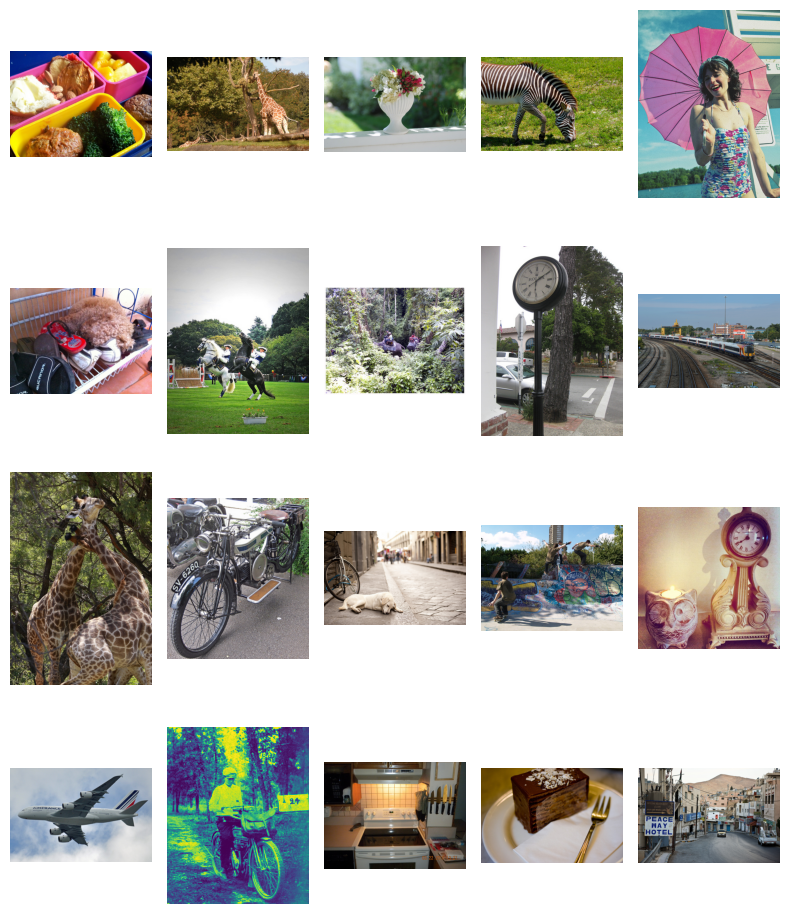

In [2]:
import os
from datasets import load_dataset
from matplotlib import pyplot as plt

dataset = load_dataset(path="detection-datasets/coco", split="train", streaming=True)

IMAGE_FOLDER = "images"
N_IMAGES = 20

# For plotting
plot_cols = 5
plot_rows = N_IMAGES // plot_cols
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(plot_rows*2, plot_cols*2))
axes = axes.flatten()

# Write the images to a folder
dataset_iter = iter(dataset)
os.makedirs(IMAGE_FOLDER, exist_ok=True)
for i in range(N_IMAGES):
    image = next(dataset_iter)['image']
    axes[i].imshow(image)
    axes[i].axis("off")

    image.save(f"images/{i}.jpg")

plt.tight_layout()
plt.show()

In [4]:
import chromadb
client = chromadb.Client()

from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader

embedding_function = OpenCLIPEmbeddingFunction()
image_loader = ImageLoader()

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

c:\Users\USER\anaconda3\envs\chromadb\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [5]:
collection = client.create_collection(
    name='multimodal_collection', 
    embedding_function=embedding_function, 
    data_loader=image_loader)

In [6]:
# Get the uris to the images
image_uris = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER)])
ids = [str(i) for i in range(len(image_uris))]

collection.add(ids=ids, uris=image_uris)

animals 라는 단어를 통해 쿼리를 추출하면 동물 관련 이미지들을 찾아서 보여준다.

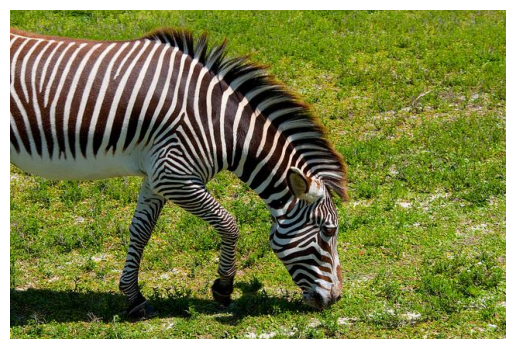

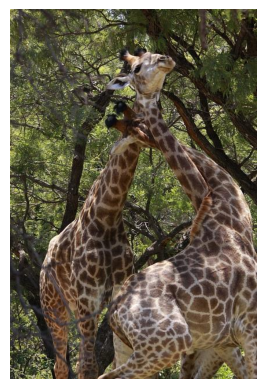

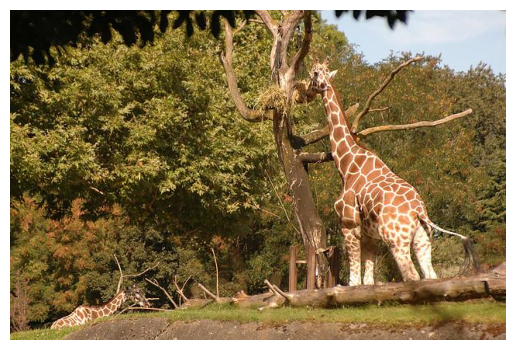

In [7]:
retrieved = collection.query(query_texts=["animals"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

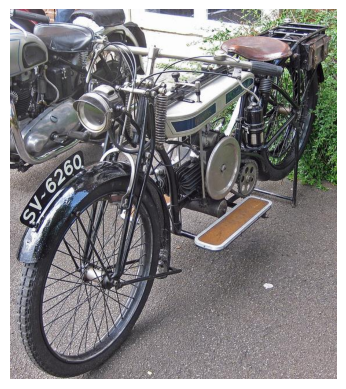

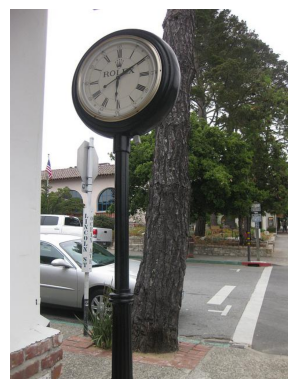

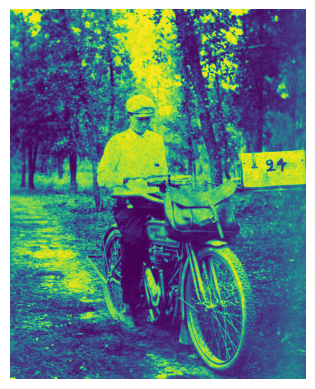

In [8]:
retrieved = collection.query(query_texts=["vehicles"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

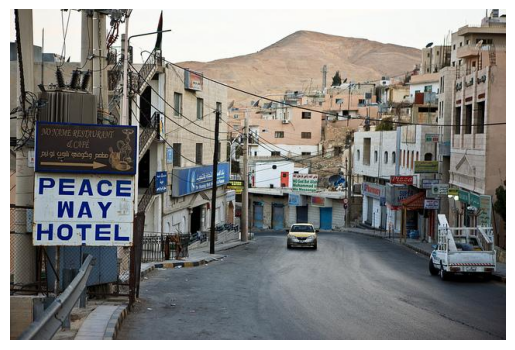

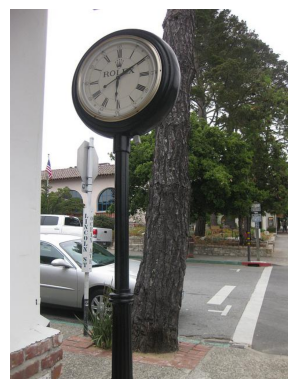

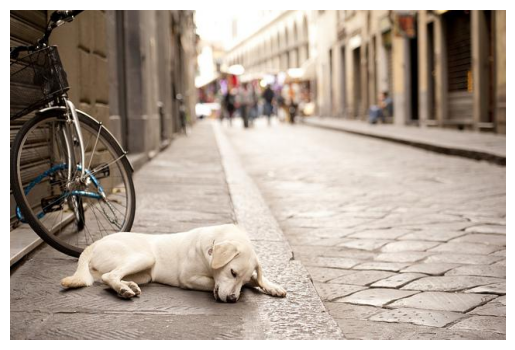

In [9]:
retrieved = collection.query(query_texts=["street scene"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

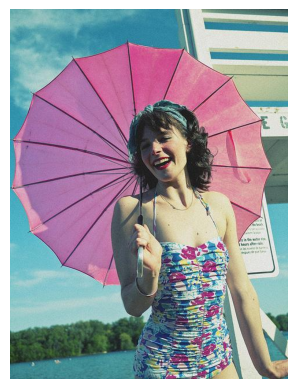

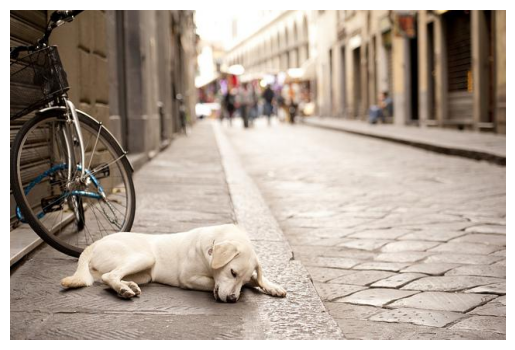

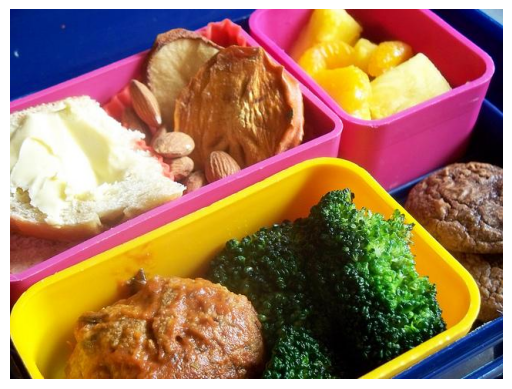

In [13]:
retrieved = collection.query(query_texts=["What is the happy?"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

즉 document 검색과 똑같이 작동한다.  
키워드랑 문장을 입력하면 임베딩 벡터로 만든 뒤, 이를 바탕으로 유사도가 높은 이미지를 추출한다

Query Image


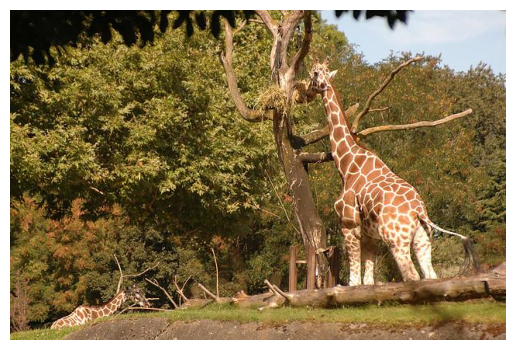

Results


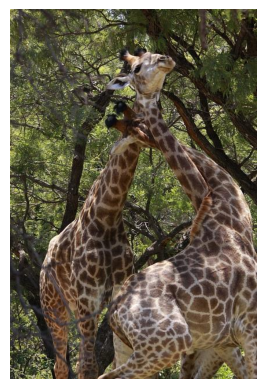

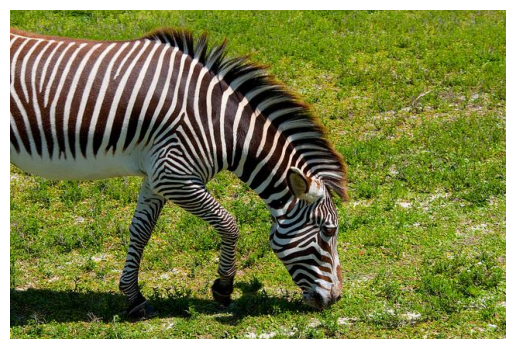

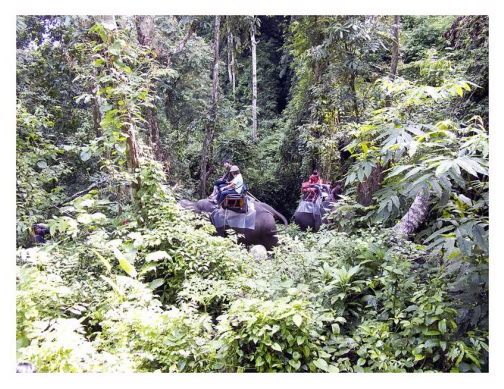

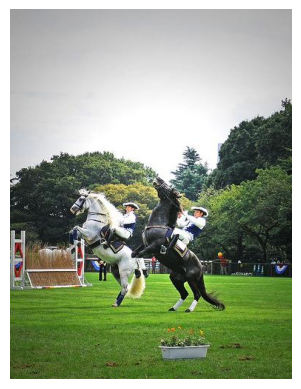

In [10]:
from PIL import Image
import numpy as np

query_image = np.array(Image.open(f"{IMAGE_FOLDER}/1.jpg"))
print("Query Image")
plt.imshow(query_image)
plt.axis('off')
plt.show()

print("Results")
retrieved = collection.query(query_images=[query_image], include=['data'], n_results=5)
for img in retrieved['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

uri를 활용하여 이미지 자체를 활용하여 유사한 이미지들을 찾을 수 있다.  
index 1 이미지가 기린인데 쿼리를 추출한 결과 동물 관련 이미지들이 나오는 것을 확인할 수 있다.

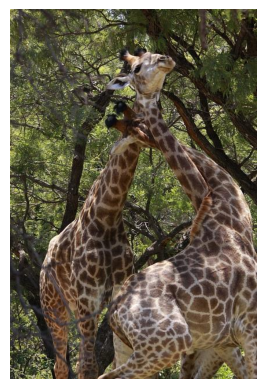

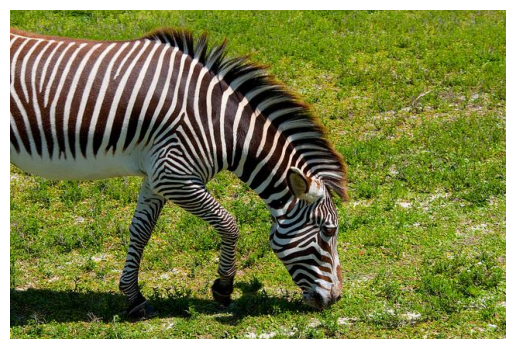

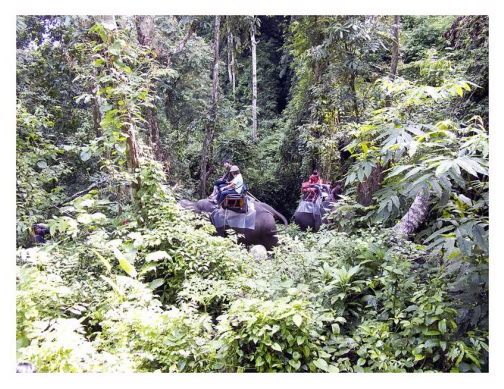

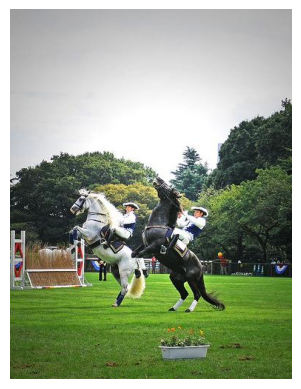

In [11]:
query_uri = image_uris[1]

query_result = collection.query(query_uris=query_uri, include=['data'], n_results=5)
for img in query_result['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()